In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall
import pandas as pd

In [2]:
# Load the data
data = np.load('character_images_dataset.npz', allow_pickle=True)
images = data['images']
features = data['features']
paths = data['paths']
names = data['names']

# Ensure the features are in a suitable format for training
features = np.stack(features).astype(np.float32)

# Shuffle and split the data into training, validation, and test sets
train_images, temp_images, train_features, temp_features = train_test_split(
    images, features, test_size=0.2, random_state=42, shuffle=True)

val_images, test_images, val_features, test_features = train_test_split(
    temp_images, temp_features, test_size=0.5, random_state=42, shuffle=True)

train_images = train_images.astype(np.float32)
val_images = val_images.astype(np.float32)
test_images = test_images.astype(np.float32)

print('Train images shape:', train_images.shape)
print('Validation images shape:', val_images.shape)
print('Test images shape:', test_images.shape)


Train images shape: (379853, 32, 32, 3)
Validation images shape: (47482, 32, 32, 3)
Test images shape: (47482, 32, 32, 3)


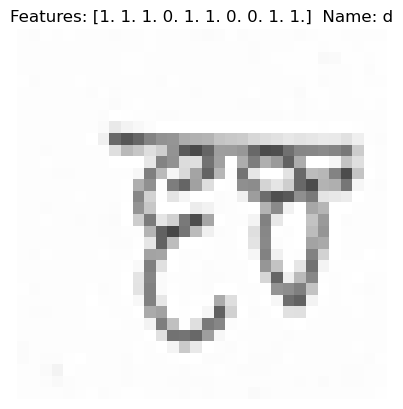

In [26]:
random_index = np.random.randint(0, len(train_images))
plt.imshow(train_images[random_index])  # No need to reshape or use grayscale colormap
plt.title(f'Features: {train_features[random_index]}  Name: {names[random_index]}')
plt.axis('off')
plt.show()

In [10]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(train_features.shape[1], activation='sigmoid')
])

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up the learning rate scheduler callback
learningRate = LearningRateScheduler(scheduler)

# Choose an optimizer
# optimizer = Adam(learning_rate=0.001)
optimizer = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

# Compile the model
model.compile(optimizer = optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy', Precision(), Recall()])
print('Train images shape:', train_images.shape)

Train images shape: (379853, 32, 32, 3)


In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, verbose=1)
history = model.fit(train_images, train_features, epochs=10, batch_size=32, 
                    validation_data=(val_images, val_features), callbacks = [learningRate, early_stopping])

# Evaluate the model
model.evaluate(test_images, test_features)

Epoch 1/10
11871/11871 [==============================] - 347s 29ms/step - loss: 0.2614 - accuracy: 0.5116 - precision_2: 0.8271 - recall_2: 0.5556 - val_loss: 0.2551 - val_accuracy: 0.5087 - val_precision_2: 0.7894 - val_recall_2: 0.6555
Epoch 2/10
11871/11871 [==============================] - 349s 29ms/step - loss: 0.2421 - accuracy: 0.5166 - precision_2: 0.8185 - recall_2: 0.6183 - val_loss: 0.2471 - val_accuracy: 0.5197 - val_precision_2: 0.7815 - val_recall_2: 0.7252
Epoch 3/10
11871/11871 [==============================] - 354s 30ms/step - loss: 0.2247 - accuracy: 0.5264 - precision_2: 0.8266 - recall_2: 0.6604 - val_loss: 0.2460 - val_accuracy: 0.5102 - val_precision_2: 0.7430 - val_recall_2: 0.7394
Epoch 4/10
11871/11871 [==============================] - 350s 29ms/step - loss: 0.2072 - accuracy: 0.5337 - precision_2: 0.8383 - recall_2: 0.6976 - val_loss: 1.5081 - val_accuracy: 0.5083 - val_precision_2: 0.3156 - val_recall_2: 0.9952
Epoch 5/10
11871/11871 [====================

[0.7277747392654419,
 0.5072027444839478,
 0.3952721655368805,
 0.8927758932113647]

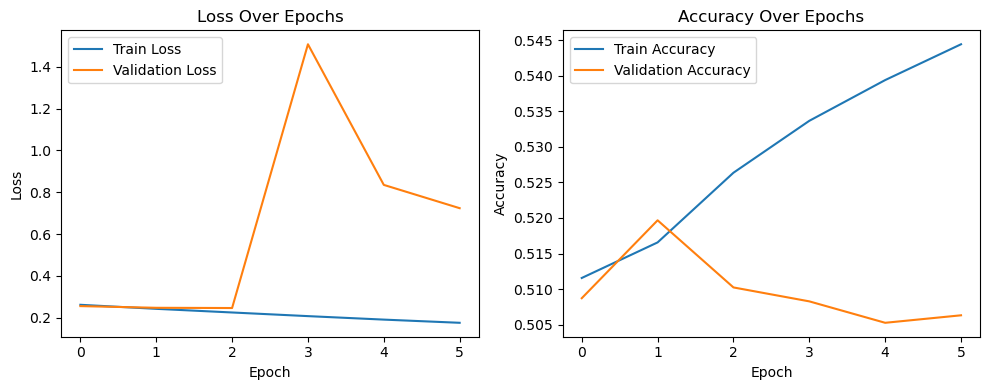

In [13]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


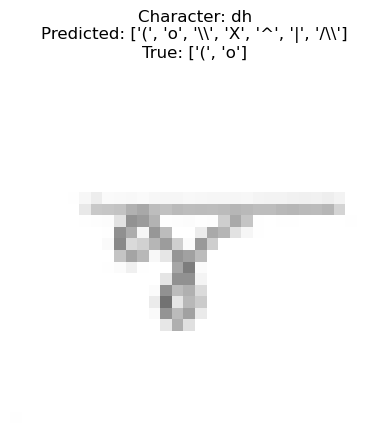

Predicted Features: ['(', 'o', '\\', 'X', '^', '|', '/\\']
Actual Features: ['(', 'o']


In [36]:
# Assuming you've loaded test_images and test_features from your npz file or through your split
# For demonstration, let's say we randomly pick an image from the test set
# np.random.seed(42)  # For reproducibility
random_index = np.random.randint(0, len(test_images))  # Get a random index

# Select the random image and its true features
random_image = test_images[random_index]
random_name = names[random_index]
true_features = test_features[random_index]

# Function to prepare the image
def prepare_image(img_array):
    img_array = img_array.reshape(32, 32, 3)  # Correctly reshape to 32x32 with 3 channels

    # Neural networks typically expect a batch dimension as well, so add that
    img_array = img_array[np.newaxis, :]  # Add a batch dimension

    # Ensure the pixel values are appropriately scaled (if they're not already)
    if img_array.max() > 1:
        img_array = img_array / 255.0  # Normalize to [0, 1]

    return img_array

# Prepare the randomly selected image
prepared_image = prepare_image(random_image)

predictions = model.predict(prepared_image)
threshold = 0.5  # Set a threshold for deciding feature presence
predicted_features = (predictions > threshold).astype(int)

# Assuming you have a list of feature names corresponding to the output neurons
feature_names = ['(', 'o', '\\', '||', 'X', '^', 'v', '>', '|', '/\\']
predicted_feature_labels = [feature_names[i] for i in range(len(feature_names)) if predicted_features[0, i] == 1]
true_feature_labels = [feature_names[i] for i in range(len(feature_names)) if true_features[i] == 1]

# Show the image and the prediction results
plt.imshow(random_image.reshape(32, 32, 3), cmap='gray')  # Make sure to adjust if your images are not grayscale
plt.title(f'Character: {random_name}\nPredicted: {predicted_feature_labels}\nTrue: {true_feature_labels}')
plt.axis('off')
plt.show()

print("Predicted Features:", predicted_feature_labels)
print("Actual Features:", true_feature_labels)

In [18]:
model.save('custom_cnn_model_1')  # Saves as a TensorFlow SavedModel 

loaded_model = load_model('custom_cnn_model_1')
loaded_model.summary()

INFO:tensorflow:Assets written to: custom_cnn_model_1/assets
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 30, 30, 32)        896       
_________________________________________________________________
batch_normalization_6 (Batch (None, 30, 30, 32)        128       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 12, 12, 128)       73856     
___________________________________________________________

In [19]:
base_model_resnet = ResNet50(weights='imagenet', include_top=False, input_tensor=Input(shape=(32, 32, 3)))

# Adding custom Top layers for our specific dataset
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_resnet = Dense(train_features.shape[1], activation='sigmoid')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output_resnet)

# Freeze the layers of the base model
for layer in base_model_resnet.layers:
    layer.trainable = False

def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up the learning rate scheduler callback
learningRate = LearningRateScheduler(scheduler)

# Choose an optimizer
optimizer = Adam(learning_rate=0.001)

# Compile the ResNet model
model_resnet.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

94781440/94765736 [==============================] - 1s 0us/step


In [20]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 3, verbose=1)
history = model_resnet.fit(train_images, train_features, epochs=10, batch_size=32, 
                    validation_data=(val_images, val_features), callbacks = [learningRate, early_stopping])

# Evaluate the model
model_resnet.evaluate(test_images, test_features)

Epoch 1/10
11871/11871 [==============================] - 470s 39ms/step - loss: 0.2801 - accuracy: 0.5109 - val_loss: 0.2754 - val_accuracy: 0.5087
Epoch 2/10
11871/11871 [==============================] - 480s 40ms/step - loss: 0.2716 - accuracy: 0.5109 - val_loss: 0.2729 - val_accuracy: 0.5087
Epoch 3/10
11871/11871 [==============================] - 493s 42ms/step - loss: 0.2680 - accuracy: 0.5110 - val_loss: 0.2690 - val_accuracy: 0.5088
Epoch 4/10
11871/11871 [==============================] - 489s 41ms/step - loss: 0.2655 - accuracy: 0.5110 - val_loss: 0.2645 - val_accuracy: 0.5087
Epoch 5/10
11871/11871 [==============================] - 486s 41ms/step - loss: 0.2635 - accuracy: 0.5111 - val_loss: 0.2637 - val_accuracy: 0.5090
Epoch 6/10
11871/11871 [==============================] - 482s 41ms/step - loss: 0.2622 - accuracy: 0.5111 - val_loss: 0.2621 - val_accuracy: 0.5087
Epoch 7/10
11871/11871 [==============================] - 498s 42ms/step - loss: 0.2610 - accuracy: 0.5113

[0.2588142454624176, 0.5119624137878418]

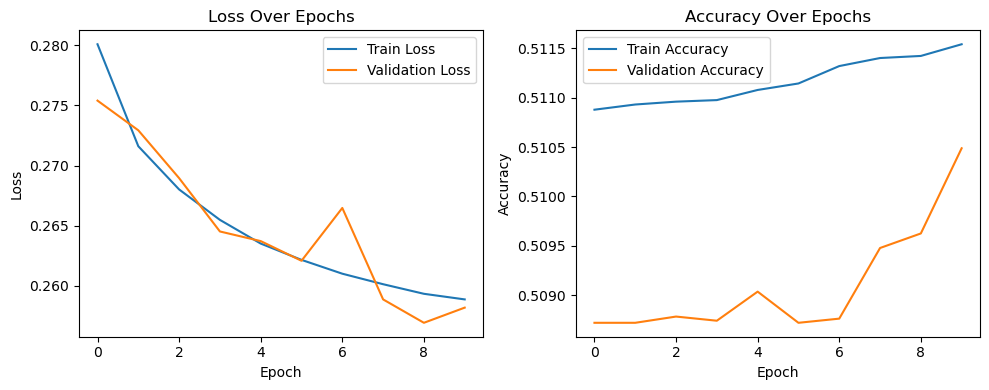

In [21]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plotting the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
